In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from openforcefield.topology import Molecule, Topology

from openff.system.stubs import ForceField

In [2]:
# Construct a single-molecule system from toolkit classes
mol = Molecule.from_smiles('CCO')
mol.generate_conformers(n_conformers=1)
top = Topology.from_molecules([mol])
parsley = ForceField('openff-1.0.0.offxml')
mysys = parsley.create_openff_system(topology=top)
bonds = mysys.handlers['Bonds']

In [3]:
# Transform parameters into matrix representations
p = bonds.get_force_field_parameters()
mapping = bonds.get_mapping()
q = bonds.get_system_parameters()
m = bonds.get_param_matrix()

In [4]:
# force field parameters, each row is something like [k (kcal/mol/A), length (A)]
p

DeviceArray([[5.3113739e+02, 1.5203758e+00],
             [7.5809320e+02, 1.0928884e+00],
             [6.6914154e+02, 1.4142879e+00],
             [1.1205833e+03, 9.7076875e-01]], dtype=float32)

In [5]:
# system parameters, a.k.a. force field parameters as they exist in a parametrized system
q

DeviceArray([[5.3113739e+02, 1.5203758e+00],
             [7.5809320e+02, 1.0928884e+00],
             [7.5809320e+02, 1.0928884e+00],
             [7.5809320e+02, 1.0928884e+00],
             [6.6914154e+02, 1.4142879e+00],
             [7.5809320e+02, 1.0928884e+00],
             [7.5809320e+02, 1.0928884e+00],
             [1.1205833e+03, 9.7076875e-01]], dtype=float32)

In [6]:
# m is the parametrization matrix, which can be dotted with p to get out q
assert np.allclose(m.dot(p.flatten()).reshape((-1, 2)), q)

m

DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [7]:
# save and set initial values
q0 = q
p0 = p

# set learning rate
a = 0.1

In [8]:
from copy import deepcopy

In [9]:
# let jax run with autodiff
_, f_vjp_bonds = jax.vjp(bonds.parametrize, jnp.asarray(p))

In [10]:
q_target = deepcopy(q0)

# modify a few of the targets to arbitrary values;
# this mimic some "true" values we wish to tune to
q_target[0, 1] = 1.8
q_target[4, 1] = 1.2
q_target[-1, 1] = 0.8


# create a dummy loss function via faking known target parameters;
# this should probably be something like the the squared difference
# between computed and reference energies
def loss(q):
    return (q - q_target)

In [11]:
# derivative of loss function evaluated at the original system parameters;
# note that column 0 mathces target values, so the derivate is flat
f_vjp_bonds(loss(q0))

(DeviceArray([[ 0.        , -0.2796241 ],
              [ 0.        ,  0.        ],
              [ 0.        ,  0.21428788],
              [ 0.        ,  0.17076874]], dtype=float32),)

step 0	loss: 0.12414940446615219
step 10	loss: 0.015093667432665825
step 20	loss: 0.0018350386526435614
step 30	loss: 0.00022309676569420844
step 40	loss: 2.7124058760819025e-05
step 50	loss: 3.2975722206174396e-06
step 60	loss: 4.0098871068039443e-07
step 70	loss: 4.876030246236951e-08
step 80	loss: 5.943267211705461e-09
step 90	loss: 7.209450814116281e-10


(0.5, 2.0)

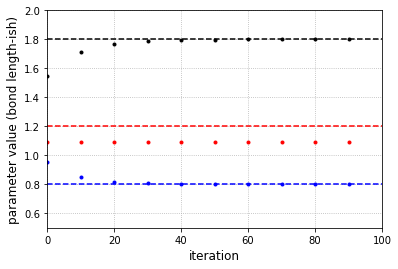

In [12]:
fig, ax = plt.subplots()

# label target values
ax.hlines(1.8, 0, 100, color='k', ls='--')
ax.hlines(1.2, 0, 100, color='r', ls='--')
ax.hlines(0.8, 0, 100, color='b', ls='--')

for i in range(100):
    # use jax to get the gradient
    grad = f_vjp_bonds(loss(q))[0]
    # update force field parameters
    p -= a * grad
    # use the parametrization matrix to propagate new
    # force field parameters into new system parameters
    q = m.dot(p.flatten()).reshape((-1, 2))
    if i % 10 == 0:
        print(f'step {i}\tloss: {np.sum(loss(q) ** 2)}')
        ax.plot(i, p[0][1], 'k.')
        ax.plot(i, p[1][1], 'r.')
        ax.plot(i, p[3][1], 'b.')

ax.set_xlabel('iteration')
ax.set_ylabel('parameter value (bond length-ish)')
ax.set_xlim((0, 100))
ax.set_ylim((0.5, 2.0))

In [13]:
# We can do everything all over again with angles, almost identically
angles = mysys.handlers['Angles']
q0 = angles.get_system_parameters()
p0 = angles.get_force_field_parameters()
mapping = angles.get_mapping()
m = angles.get_param_matrix()
q = q0
p = p0
a = 0.1

q_target = deepcopy(q0)
q_target[:, 1] -= 5

def loss(q):
    return (q - q_target)

_, f_vjp_angles = jax.vjp(angles.parametrize, jnp.asarray(p))

step 0	loss: 64.25
step 10	loss: 2.4632463455200195
step 20	loss: 0.2993059754371643
step 30	loss: 0.036385610699653625
step 40	loss: 0.004423987120389938
step 50	loss: 0.0005375783075578511
step 60	loss: 6.527901859954e-05
step 70	loss: 7.92584614828229e-06
step 80	loss: 9.539071470499039e-07
step 90	loss: 1.1292286217212677e-07


(100.0, 110.0)

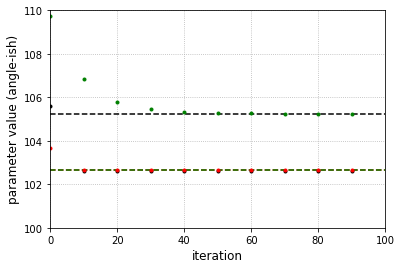

In [14]:
fig, ax = plt.subplots()

# label target values
ax.hlines(105.25177978, 0, 100, color='k', ls='--')
ax.hlines(102.66078218, 0, 100, color='r', ls='--')
ax.hlines(102.66078218, 0, 100, color='g', ls='--')

for i in range(100):
    # use jax to get the gradient
    grad = f_vjp_angles(loss(q))[0]
    # update force field parameters
    p -= a * grad
    # print(p[0])
    q = m.dot(p.flatten()).reshape((-1, 2))
    if i % 10 == 0:
        print(f'step {i}\tloss: {np.sum(loss(q) ** 2)}')
        ax.plot(i, p[2][1], 'k.')
        ax.plot(i, p[0][1], 'r.')
        ax.plot(i, p[1][1], 'g.')

ax.set_xlabel('iteration')
ax.set_ylabel('parameter value (angle-ish)')
ax.set_xlim((0, 100))
ax.set_ylim((100, 110))

Based on some discussions with YTZ and others, it's likely intractable to have a _single_ matrix that globally represents the entire set of force field parameters $\textit{P}$ because it scales poorly with system size and complexity; consider the corresponding system parameter matrix $\textit{Q}$ and the mapping matrix between them $\textit{M}$. A different approach involves by separating things into individual handlers which each store data and logic for how to manage said data. This naturally mirrors the intent of handlers in the toolkit's force field class, albeit with some complexity in how electrostatics are actually processed. JAX seems to be able to reconstruct this later on, i.e. drive a grand optimization by summing smaller VJPs. Other libraries may require porting, if they can even handle the heterogenous optimizations we care about (TBD).

The above demonstrates the two easiest handlers; bonds and angles are relatively small amounts of data, map back onto chemical topology cleanly, and are not meaningfully represented by sparse matrices. Propers and impropers introduce more issues. The next steps are to construct more meaningful loss functions and try to optimize bonds and angles simultaneously.